# Описание

## Задачи
_Испольуется три задачи:_
- DM -- двухальтернативный выбор
- Romo -- сравнение двух сигнало через задержку
- CtxDM -- DM с контекстом
Вход состоит из одного контекстного входа, одного стимула, 6 входов, кодирующих задачи. Выход как и раньше состоит из трех частей: контекстный выход, выходы принятия решения.

## Сеть
 Сеть состоит из lif AdEx нейронов

# Импорт всех необходимых библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from cgtasknet.instruments.instrument_accuracy_network import CorrectAnswerNetwork
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
)
from tqdm import tqdm


In [2]:
go_task_list_values = np.linspace(0, 1, 8)

# Определяем устройство

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device={device}")

device=cuda:0


# Функция построения входов и выходов

In [4]:
import os


def plot_results(inputs, target_outputs, outputs):
    if isinstance(inputs, torch.Tensor) and isinstance(target_outputs, torch.Tensor):
        inputs, t_outputs = (
            inputs.detach().cpu().numpy(),
            target_outputs.detach().cpu().numpy(),
        )
    for bath in range(min(batch_size, 20)):
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(141)
        plt.title("Inputs")
        plt.xlabel("$time, ms$")
        plt.ylabel("$Magnitude$")
        for i in range(3):
            plt.plot(inputs[:, bath, i].T, label=rf"$in_{i + 1}$")
        plt.legend()
        plt.tight_layout()

        ax2 = fig.add_subplot(142)
        plt.title("Task code (context)")
        plt.xticks(np.arange(1, len(tasks) + 1), sorted(tasks), rotation=90)
        plt.yticks([])
        for i in range(3, inputs.shape[-1]):
            plt.plot([i - 2] * 2, [0, inputs[0, bath, i]])
        plt.tight_layout()

        ax3 = fig.add_subplot(143)
        plt.title("Target output")
        plt.xlabel("$time, ms$")
        for i in range(t_outputs.shape[-1]):
            plt.plot(t_outputs[:, bath, i], label=rf"$out_{i + 1}$")
        plt.legend()
        plt.tight_layout()

        ax4 = fig.add_subplot(144)
        plt.title("Real output")
        plt.xlabel("$time, ms$")
        for i in range(outputs.shape[-1]):
            plt.plot(
                outputs.detach().cpu().numpy()[:, bath, i], label=rf"$out_{i + 1}$"
            )
        plt.legend()
        plt.tight_layout()
        if not os.path.exists("figures"):
            os.mkdir("figures")
        plt.savefig(f"figures{os.sep}network_outputs_{name}_batch_{bath}.pdf")
        plt.show()
        plt.close()

# Определяем датасет
Датасет будет состоять из трех типов задач:
- DM задача;
- Romo задача;
- CtxDM задача.
_Параметры для последней задачи аналогичны DM задаче_
***
## Параметры датасета:

In [5]:
batch_size = 50
number_of_epochs = 3000
number_of_tasks = 2
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.2,
        positive_shift_delay_time=1.5,
        trial_time=0.2,
        positive_shift_trial_time=0.4,
        answer_time=.25
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.5, answer_time=.25)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=.25
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        answer_time=1,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(trial_time=0.2, positive_shift_trial_time=0.4, answer_time=.25, value=go_task_list_values),
        delay=0.2,
        positive_shift_delay_time=1.5,

    )
)

## Датасет

In [6]:
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}
Task = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    mode="random",
)

print("Task parameters:")
for key in task_dict:
    print(f"{key}:\n{task_dict[key]}\n")

print(f"inputs/outputs: {Task.feature_and_act_size[0]}/{Task.feature_and_act_size[1]}")

Task parameters:
RomoTask1:
RomoTaskRandomModParameters(romo=RomoTaskParameters(dt=0.001, trial_time=0.2, answer_time=0.25, value=(None, None), delay=0.2, negative_shift_trial_time=0, positive_shift_trial_time=0.4, negative_shift_delay_time=0, positive_shift_delay_time=1.5), n_mods=2)

RomoTask2:
RomoTaskRandomModParameters(romo=RomoTaskParameters(dt=0.001, trial_time=0.2, answer_time=0.25, value=(None, None), delay=0.2, negative_shift_trial_time=0, positive_shift_trial_time=0.4, negative_shift_delay_time=0, positive_shift_delay_time=1.5), n_mods=2)

DMTask1:
DMTaskRandomModParameters(dm=DMTaskParameters(dt=0.001, trial_time=0.3, answer_time=0.25, value=None, negative_shift_trial_time=0, positive_shift_trial_time=1.5), n_mods=2)

DMTask2:
DMTaskRandomModParameters(dm=DMTaskParameters(dt=0.001, trial_time=0.3, answer_time=0.25, value=None, negative_shift_trial_time=0, positive_shift_trial_time=1.5), n_mods=2)

CtxDMTask1:
CtxDMTaskParameters(dm=DMTaskParameters(dt=0.001, trial_time=0.3,

## Пример генерации датасета

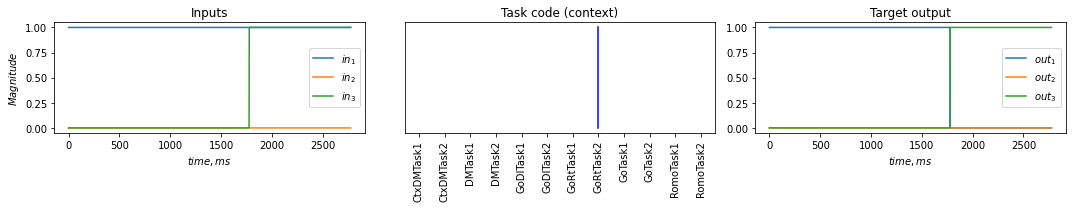

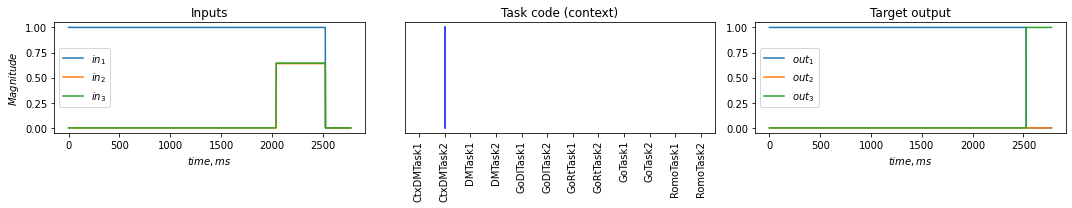

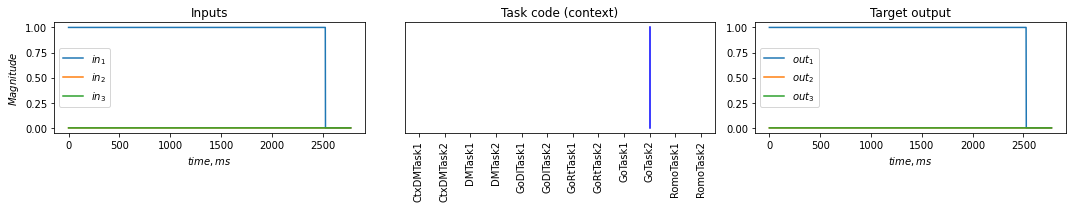

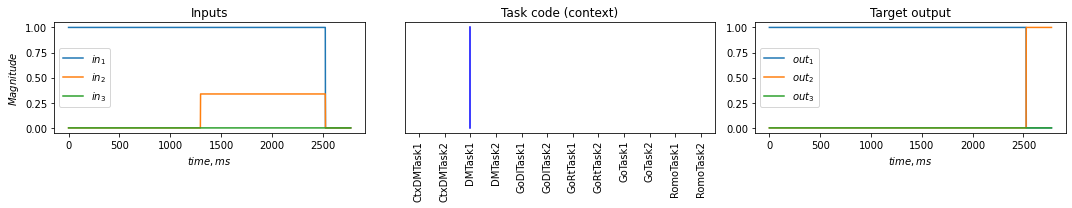

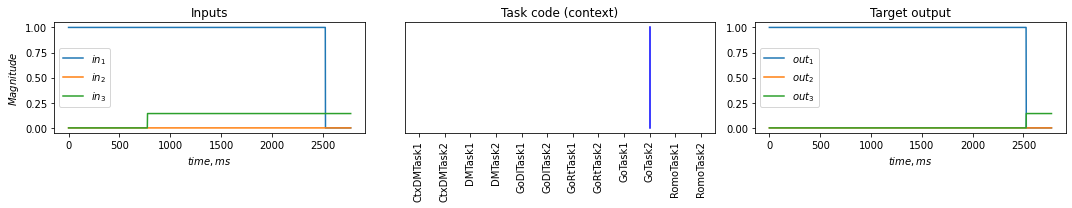

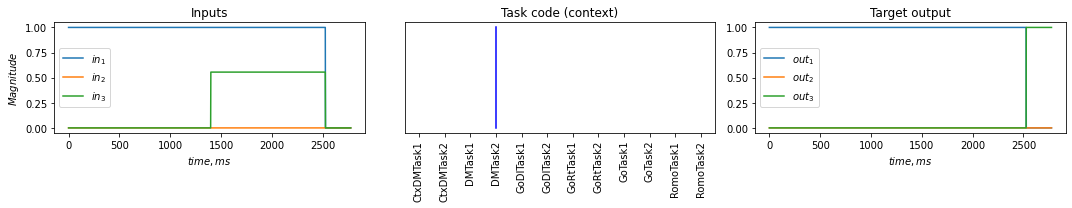

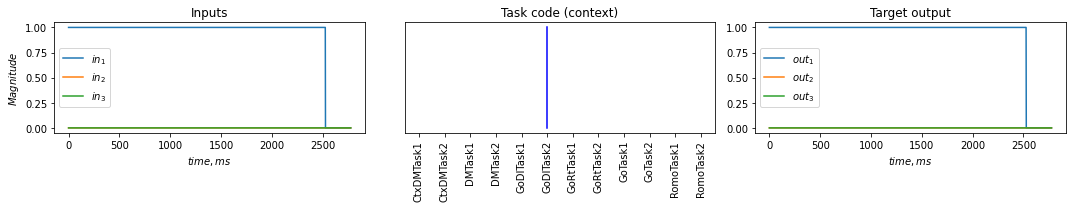

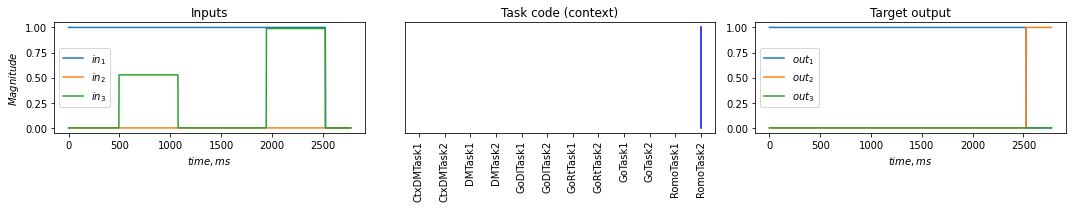

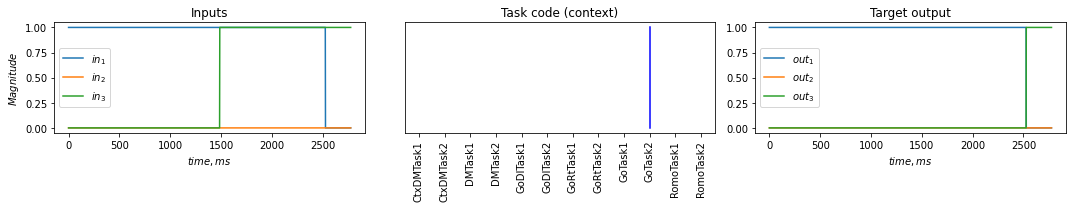

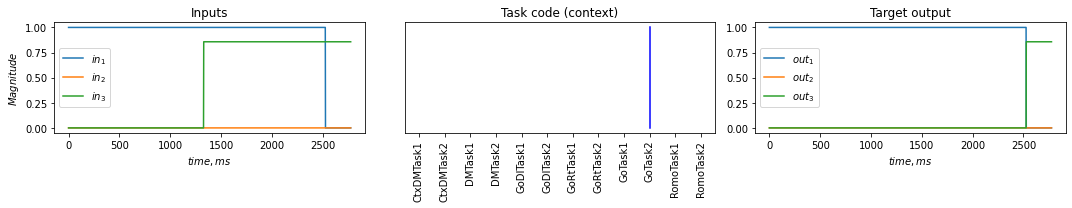

In [7]:
inputs, t_outputs = Task.dataset(n_trials=1, delay_between=0)
for bath in range(min(batch_size, 10)):
    fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(131)
    plt.title("Inputs")
    plt.xlabel("$time, ms$")
    plt.ylabel("$Magnitude$")
    for i in range(3):
        plt.plot(inputs[:, bath, i], label=rf"$in_{i + 1}$")
    plt.legend()
    plt.tight_layout()

    ax2 = fig.add_subplot(132)
    plt.title("Task code (context)")
    plt.xticks(np.arange(1, len(tasks) + 1), sorted(tasks), rotation=90)
    plt.yticks([])
    for i in range(3, inputs.shape[-1]):
        plt.plot([i - 2] * 2, [0, inputs[0, bath, i]], c="b")
    # plt.legend()
    plt.tight_layout()

    ax3 = fig.add_subplot(133)
    plt.title("Target output")
    plt.xlabel("$time, ms$")
    for i in range(t_outputs.shape[-1]):
        plt.plot(t_outputs[:, bath, i], label=rf"$out_{i + 1}$")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
del inputs
del t_outputs

In [8]:
sorted_tasks = sorted(tasks)
re_word = 'Go'
choices_tasks = []
values_tasks = []
for i in range(len(sorted_tasks)):
    if re_word in sorted_tasks[i]:
        values_tasks.append(i)
    else:
        choices_tasks.append(i)
can = CorrectAnswerNetwork(choices_tasks, values_tasks, 0.15)

In [9]:
values_tasks

[4, 5, 6, 7, 8, 9]

# Инициализация сети и выгрузка на device

In [10]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

feature_size, output_size = Task.feature_and_act_size
hidden_size = 600
tau_a = 1/2
neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.65),
    tau_ada_inv=torch.as_tensor(tau_a),
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
).to(device)


# Критерий и функция ошибки

In [11]:
learning_rate = 5e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


class MaskedMSELoss(torch.nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, input, target, mask):
        diff2 = (torch.flatten(input) - torch.flatten(target)) ** 2.0 * torch.flatten(mask)
        result = torch.sum(diff2) / torch.sum(mask)
        return result


criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Генерация всех эпох
> Если память не позволяет, то необходимо генерировать каждую эпоху в основном цикле обучения

In [12]:
if False:
    list_inputs = []
    list_t_outputs = []
    for i in tqdm(range(number_of_epochs)):
        temp_input, temp_t_output = Task.dataset()
        temp_input.astype(dtype=np.float16)
        temp_t_output.astype(dtype=np.float16)
        temp_input[:, :, :] += np.random.normal(0, sigma, size=temp_input.shape)
        list_inputs.append(temp_input)
        list_t_outputs.append(temp_t_output)

# JIT numba generator (test)
TODO: Необходимо добавить в cgtasknet и вызывать оттуда

In [13]:
def every_bath_generator(
        start_sigma: float,
        stop_sigma: float,
        times: int = 1,
        batches: int = 1,
        actions: int = 1,
):
    data = np.zeros((times, batches, actions))
    for i in range(batches):
        data[:, i, :] = np.random.normal(
            0, np.random.uniform(start_sigma, stop_sigma), size=(times, actions)
        )
    return data

# Основной цикл обучения

In [14]:
from cgtasknet.instruments.instrument_accuracy_network import correct_answer
from cgtasknet.net.states import LIFAdExInitState
from norse.torch import LIFAdExState

name = f"Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_{neuron_parameters.alpha}_N_{hidden_size}"
init_state = LIFAdExInitState(batch_size, hidden_size, device=device)
running_loss = 0
sigma = 0
for i in tqdm(range(number_of_epochs)):
    if i == 500:
        sigma = 0.2
    if i == 1000:
        sigma = 0.5
    inputs, target_outputs = Task.dataset(number_of_tasks)

    inputs[:, :, 1:3] += every_bath_generator(
        0, sigma, inputs.shape[0], inputs.shape[1], 2
    )
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    loss_mask = torch.zeros_like(target_outputs)
    mask_indexes_signes = torch.where(target_outputs[:, :, 0] == 1)
    mask_indexes_zeros = torch.where(target_outputs[:, :, 0] == 0)
    loss_mask[mask_indexes_signes[0], mask_indexes_signes[1], :] = 1
    loss_mask[mask_indexes_zeros[0], mask_indexes_zeros[1], :] = 5
    optimizer.zero_grad()
    init_state = LIFAdExState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
    )
    # forward + backward + optimize
    outputs, _ = model(inputs, init_state)

    loss = criterion(outputs, target_outputs, loss_mask)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 50 == 49:
        with open("log_multy.txt", "a") as f:
            f.write("epoch: {:d} loss: {:0.5f}\n".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            torch.save(
                model.state_dict(),
                name,
            )
    if i % 50 == 49:

        result = 0
        for j in range(10):
            try:
                del inputs
            except:
                pass
            try:
                del target_outputs
            except:
                pass
            try:
                del outputs
            except:
                pass
            torch.cuda.empty_cache()
            inputs, target_outputs = Task.dataset(1, delay_between=0)
            inputs[:, :, 1:3] += every_bath_generator(
                0, 0.01, inputs.shape[0], inputs.shape[1], 2
            )
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs = model(inputs)[0]
            type_tasks = list(np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1])
            answers = can.run(target_outputs[50:, :, 0].cpu(), outputs[50:, :, 0].cpu(),
                              target_outputs[50:, :, 1:].cpu(), outputs[50:, :, 1:].cpu(), type_tasks)
            result += answers

        accuracy = result / batch_size / 10 * 100
        with open("accuracy_multy.txt", "a") as f:
            f.write(f"ecpoch = {i}; correct/all = {accuracy}\n")
    try:
        del inputs
    except:
        pass
    try:
        del target_outputs
    except:
        pass
    try:
        del outputs
    except:
        pass
    torch.cuda.empty_cache()
print("Finished Training")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [16:54:38<00:00, 20.29s/it]

Finished Training


In [15]:
sorted_tasks = sorted(tasks)
re_word = 'Go'
choices_tasks = []
values_tasks = []
for i in range(len(sorted_tasks)):
    if re_word in sorted_tasks[i]:
        values_tasks.append(i)
    else:
        choices_tasks.append(i)
can = CorrectAnswerNetwork(choices_tasks, values_tasks, 0.15)
inputs, target_outputs = Task.dataset(1, delay_between=0)
inputs[:, :, 1:3] += every_bath_generator(
    0, 0.01, inputs.shape[0], inputs.shape[1], 2
)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = (
    torch.from_numpy(target_outputs).type(torch.float).to(device)
)
outputs = model(inputs)[0]
type_tasks = list(np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1])
answers = can.run(target_outputs[:, :, 0].cpu(), outputs[:, :, 0].cpu(), target_outputs[:, :, 1:].cpu(),
                  outputs[:, :, 1:].cpu(), type_tasks)
result += answers

In [16]:
go_accuracy = 0.15
can = CorrectAnswerNetwork(choices_tasks, values_tasks, go_accuracy)
start_sigma = 0
stop_sigma = 2
step_sigma = 0.05
sigma_array = np.arange(start_sigma, stop_sigma, step_sigma)
for test_sigma in tqdm(sigma_array):
    result = 0
    for j in range(20):
        try:
            del inputs
        except:
            pass
        try:
            del target_outputs
        except:
            pass
        try:
            del outputs
        except:
            pass
        torch.cuda.empty_cache()
        inputs, target_outputs = Task.dataset(1, delay_between=0)
        inputs[:, :, 1:3] += np.random.normal(0, test_sigma, size=inputs[:, :, 1:3].shape)
        inputs = torch.from_numpy(inputs).type(torch.float).to(device)
        target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
        outputs = model(inputs)[0]
        type_tasks = list(np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1])
        answers = can.run(target_outputs[50:, :, 0].cpu(), outputs[50:, :, 0].cpu(), target_outputs[50:, :, 1:].cpu(),
                          outputs[50:, :, 1:].cpu(), type_tasks)
        result += answers
    accuracy = result / batch_size / 20 * 100
    with open(f"accuracy_vs_noise_{tau_a}_{go_accuracy}.txt", "a") as f:
        f.write(f"noise={test_sigma}:accuracy={accuracy}\n")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:14:42<00:00, 112.06s/it]


In [17]:
go_accuracy = 0.07
can = CorrectAnswerNetwork(choices_tasks, values_tasks, go_accuracy)
start_sigma = 0
stop_sigma = 2
step_sigma = 0.05
sigma_array = np.arange(start_sigma, stop_sigma, step_sigma)
for test_sigma in tqdm(sigma_array):
    result = 0
    for j in range(20):
        try:
            del inputs
        except:
            pass
        try:
            del target_outputs
        except:
            pass
        try:
            del outputs
        except:
            pass
        torch.cuda.empty_cache()
        inputs, target_outputs = Task.dataset(1, delay_between=0)
        inputs[:, :, 1:3] += np.random.normal(0, test_sigma, size=inputs[:, :, 1:3].shape)
        inputs = torch.from_numpy(inputs).type(torch.float).to(device)
        target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
        outputs = model(inputs)[0]
        type_tasks = list(np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1])
        answers = can.run(target_outputs[50:, :, 0].cpu(), outputs[50:, :, 0].cpu(), target_outputs[50:, :, 1:].cpu(),
                          outputs[50:, :, 1:].cpu(), type_tasks)
        result += answers
    accuracy = result / batch_size / 20 * 100
    with open(f"accuracy_vs_noise_{tau_a}_{go_accuracy}.txt", "a") as f:
        f.write(f"noise={test_sigma}:accuracy={accuracy}\n")

  2%|█████████▌                                                                                                                                                                                                                                                                                                                                                                                   | 1/40 [01:54<1:14:29, 114.60s/it]


KeyboardInterrupt: 